In [140]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model

RANDOM_SEED = 42

# Specify each path

In [141]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [142]:
NUM_CLASSES = 11

# Dataset reading

In [143]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [144]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [146]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [147]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_14 (Dropout)        (None, 42)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                860       
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 10)                210       
                                                                 
 dense_23 (Dense)            (None, 11)                121       
                                                                 
Total params: 1191 (4.65 KB)
Trainable params: 1191 (4.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [148]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [149]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [150]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
44/44 [==============================] - ETA: 0s - loss: 2.3607 - accuracy: 0.1368
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
44/44 [==============================] - 5s 27ms/step - loss: 2.3607 - accuracy: 0.1368 - val_loss: 2.2475 - val_accuracy: 0.2220
Epoch 2/1000
44/44 [==============================] - ETA: 0s - loss: 2.2125 - accuracy: 0.2076
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
44/44 [==============================] - 1s 16ms/step - loss: 2.2125 - accuracy: 0.2076 - val_loss: 2.0766 - val_accuracy: 0.2332
Epoch 3/1000
43/44 [============================>.] - ETA: 0s - loss: 2.1085 - accuracy: 0.2329
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
44/44 [==============================] - 1s 12ms/step - loss: 2.1070 - accuracy: 0.2339 - val_loss: 1.9927 - val_accuracy: 0.2595
Epoch 4/1000
44/44 [==============================] - ETA: 0s - loss: 2.0481 - accuracy: 0.

In [151]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.8606


In [152]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [153]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 62ms/step
[8.45162570e-02 2.04974953e-02 7.44837523e-03 2.84560844e-02
 1.15389444e-01 2.66319007e-01 3.10807925e-04 4.66680080e-01
 5.49358265e-05 1.55585597e-03 8.77161510e-03]
7


# Confusion matrix

59/59 [==============================] - 0s 2ms/step


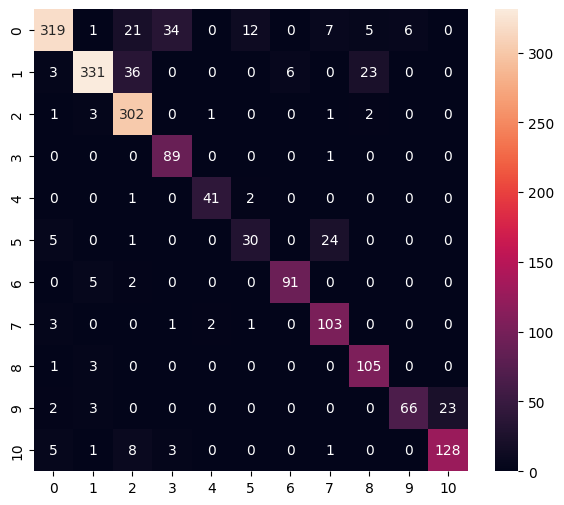

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       405
           1       0.95      0.83      0.89       399
           2       0.81      0.97      0.89       310
           3       0.70      0.99      0.82        90
           4       0.93      0.93      0.93        44
           5       0.67      0.50      0.57        60
           6       0.94      0.93      0.93        98
           7       0.75      0.94      0.83       110
           8       0.78      0.96      0.86       109
           9       0.92      0.70      0.80        94
          10       0.85      0.88      0.86       146

    accuracy                           0.86      1865
   macro avg       0.84      0.86      0.84      1865
weighted avg       0.87      0.86      0.86      1865



In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [155]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [156]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000002962FE35900>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000002962FE35900>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x000002962FE35900>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: C:\Users\rvheb\AppData\Local\Temp\tmp1cfsdig_\assets


INFO:tensorflow:Assets written to: C:\Users\rvheb\AppData\Local\Temp\tmp1cfsdig_\assets


6912

# Inference test

In [157]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [158]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [159]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [160]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [161]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.4516235e-02 2.0497506e-02 7.4483785e-03 2.8456070e-02 1.1538948e-01
 2.6631898e-01 3.1080790e-04 4.6668008e-01 5.4935826e-05 1.5558559e-03
 8.7716151e-03]
7
